In [101]:
!pip install jovian --upgrade --quiet

In [102]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [103]:
project_name='04-fashion-feedforward-nn'

In [104]:
dataset=FashionMNIST(root='data/',download=True,transform=ToTensor())
test_dataset=FashionMNIST(root='data/',train=False,transform=ToTensor())

In [105]:
val_size=10000
train_size=len(dataset)-val_size
train_ds,val_ds = random_split (dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(50000, 10000)

In [106]:
batch_size=128

In [107]:
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size*2,num_workers=4,pin_memory=True)


images.shape:  torch.Size([128, 1, 28, 28])


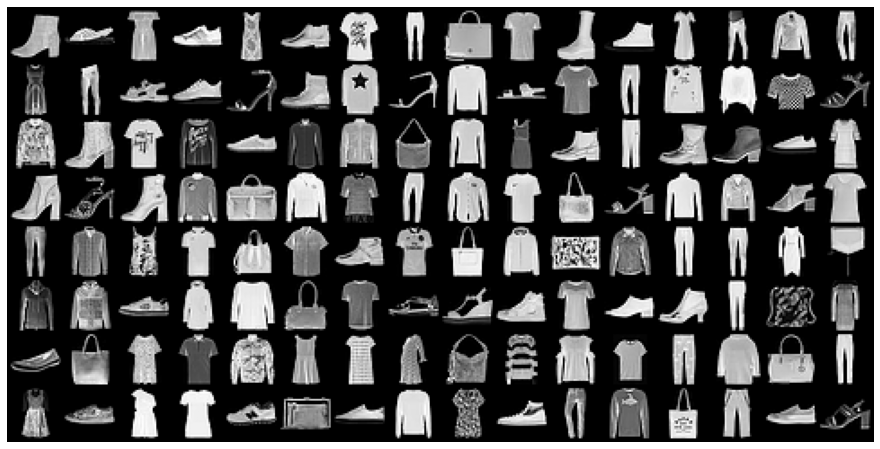

In [108]:
for images,_ in train_loader:
  print('images.shape: ',images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
  break

In [109]:
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [110]:
class MnistModel(nn.Module):
  def __init__(self,in_size,out_size):
    super().__init__()
    self.linear1=nn.Linear(in_size,16)
    self.linear2=nn.Linear(16,32)
    self.linear3=nn.Linear(32,out_size)

  def forward(self,xb):
    out=xb.view(xb.size(0),-1)
    out=self.linear1(out)
    out=F.relu(out)
    out=self.linear2(out)
    out=F.relu(out)
    out=self.linear3(out)
    return out

  def training_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    acc=accuracy(out,labels)
    return {'val_loss' :loss,'val_acc' :acc}

  def validation_epoch_end(self,outputs):
    batch_losses=[x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs=[x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(),'val_acc': epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print('Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch,result['val_loss'],result['val_acc']))

In [111]:
torch.cuda.is_available()

False

In [112]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [113]:
device=get_default_device()
device

device(type='cpu')

In [114]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

In [115]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)
    
  def __len__(self):
    return len(self.dl)

In [116]:
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)
test_loader=DeviceDataLoader(test_loader,device)

In [117]:
def evaluate(model,val_loader):
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epoch,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
  history=[]
  optimizer=opt_func(model.parameters(),lr)
  for epoch in range(epoch):
    for batch in train_loader:
      loss=model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result=evaluate(model,val_loader)
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [118]:
input_size=784
num_classes=10

In [119]:
model=MnistModel(input_size,out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [120]:
history=[evaluate(model,val_loader)]
history

[{'val_acc': 0.10673828423023224, 'val_loss': 2.3151652812957764}]

In [121]:
history+= fit(5,0.5,model,train_loader,val_loader)

Epoch [0], val_loss: 0.6101, val_acc: 0.7657
Epoch [1], val_loss: 0.5015, val_acc: 0.8174
Epoch [2], val_loss: 0.5300, val_acc: 0.8054
Epoch [3], val_loss: 0.5036, val_acc: 0.8232
Epoch [4], val_loss: 0.5773, val_acc: 0.8015


In [122]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4037, val_acc: 0.8529
Epoch [1], val_loss: 0.4006, val_acc: 0.8526
Epoch [2], val_loss: 0.4009, val_acc: 0.8570
Epoch [3], val_loss: 0.4008, val_acc: 0.8521
Epoch [4], val_loss: 0.3949, val_acc: 0.8544


Text(0.5, 1.0, 'Loss vs No of epochs')

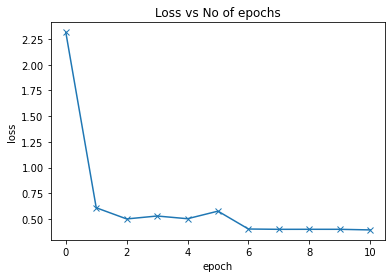

In [123]:
losses=[x['val_loss'] for x in history]
plt.plot(losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs No of epochs')

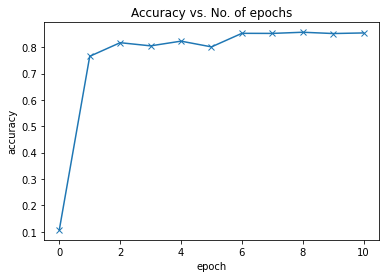

In [124]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [125]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Ankle boot , Predicted: Ankle boot


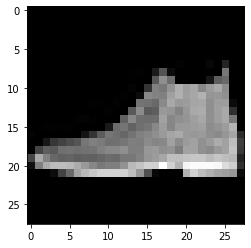

In [126]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [127]:
evaluate(model, test_loader)

{'val_acc': 0.843945324420929, 'val_loss': 0.4363190531730652}

In [128]:
saved_weights_fname='fashion-feedforward.pth'

In [129]:
torch.save(model.state_dict(), saved_weights_fname)